In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
# Class that holds a quantity which can be inflow, volume or outflow
class Quantity:
    
    def __init__(self, name, value=None, derivative=None):
        self.name = name
        
        if value == None:
            self.value = '0'
        else:
            self.value = value

        if derivative == None:
            self.derivative = '0'
        else:
            self.derivative = derivative
    
    def quantity_space(self):
        quantity_space = ['0', '+']
        if self.name != 'inflow': # Inflow doesn't have max
            quantity_space.append('max')
        return quantity_space
    
    def quantity_transition(self, trace_prints = False):     
        if self.derivative == '+':
            if len(self.quantity_space()) - 1 > self.quantity_space().index(self.value):
                self.value = self.quantity_space()[self.quantity_space().index(self.value) + 1]
            
        elif self.derivative == '-':
            if self.quantity_space().index(self.value) > 0:
                self.value = self.quantity_space()[self.quantity_space().index(self.value) - 1]

        if trace_prints:
            print('The {} {}, so there will be {} {}.'
                  .format(self.name, self.derivative_to_word(), self.value_to_word(), self.name))
                
        return self
    
    def value_to_word(self):
        if self.value == '0':
            value = 'no'
        elif self.value == '+':
            value = 'some'
        elif self.value == 'max':
            value = 'a maximum amount of'
        return value

    def derivative_to_word(self):
        if self.derivative == '0':
            derivative = 'remains the same'
        elif self.derivative == '+':
            derivative = 'is increasing'
        elif self.derivative == '-':
            derivative = 'is decreasing'   
        return derivative

    def __repr__(self):
        string = '{}: ({}, {})'.format(self.name, self.value, self.derivative)
        if len(self.name) <= 6: 
            string = string[:6] + ' ' + string[6:] # Aesthetics
            
        return string

    __str__ = __repr__
    
# Class that holds a state
class State:

    def __init__(self, inflow=None, volume=None, outflow=None):
        if inflow == None:
            self.inflow = Quantity(name='inflow')
        else:
            self.inflow = inflow
            
        if volume == None:
            self.volume = Quantity(name='volume')
        else:
            self.volume = volume
            
        if outflow == None:
            self.outflow = Quantity(name='outflow')
        else:
            self.outflow = outflow
    
    def quantities(self):
        return [self.inflow, self.volume, self.outflow]
    
    def quantity_transitions(self, quantity_name = None, trace_prints = False):
        state = copy.deepcopy(self)
        
        for quantity in state.quantities():
            if quantity_name == None or quantity_name == quantity.name:
                quantity.quantity_transition(trace_prints = trace_prints)
    
        return state
    
    def description(self):
        quantities = self.quantities()
        
        for quantity in quantities:
            value = quantity.value_to_word()
            derivative = quantity.derivative_to_word()
            
            print('There is {} {} and the {} {}.'
                  .format(value, quantity.name, quantity.name, derivative))
            
    def __repr__(self):
        return  str(self.inflow)  + '\n' + \
                str(self.volume)  + '\n' + \
                str(self.outflow) + '\n'
            
    __str__ = __repr__

In [3]:
def get_children(node, trace_prints = False):
    prototypes = []
    
    if trace_prints:
        print('The current situation:')
        node.description()
        print()
    
    count_prototypes = 0
    
    # Rule 0: Derivative changes next state's values
    if trace_prints:
        print('Rule 0: Derivative changes next state\'s values')
        
    if not (node.inflow.value == '+' and  # If there is some inflow
            node.volume.value == '+' and  # and volume
            node.volume.derivative == '-' # and even though the volume is decreasing
           ):                             # the child volume can't reach 0
        
        count_prototypes += 1
        if trace_prints:
            print('Prototype {} was created:'.format(count_prototypes))
            
        prototypes.append(node.quantity_transitions(trace_prints = trace_prints))
    
    # If there is some volume and it's derivative is not 0
    # When increasing the volume can increase but not reach maximum
    # When decreasing the volume can decrease but not reach 0
    if (node.volume.value == '+' and node.volume.derivative != '0') or \
    (node.inflow.value == '+' and node.inflow.derivative == '-'):

        if (node.volume.value == '+' and node.volume.derivative != '0'):
            quantity = node.volume
        elif (node.inflow.value == '+' and node.inflow.derivative == '-'):
            quantity = node.inflow
    
        count_prototypes += 1
        if trace_prints:
            print()
            print('Prototype {} was created:'.format(count_prototypes))
            print('There {} {} and it still {} without reaching {}, so it stays positive.'
                  .format(quantity.value_to_word(), 
                          quantity.name, 
                          quantity.derivative_to_word(),
                          copy.deepcopy(quantity).quantity_transition(trace_prints = False).value)
                 )
        if quantity.name == 'volume':
            prototypes.append(copy.deepcopy(node).quantity_transitions(quantity_name = 'inflow'))
        else:
            prototypes.append(copy.deepcopy(node))

    for count_prototypes, prototype in enumerate(prototypes):
        
        if trace_prints:
            print()
            print('For prototype no {}:'.format(count_prototypes+1))    

        # Rule 1: Count inflow value and outflow value of the current state
        # and inflow derivative of the previous state to determine the current state's
        # volume and outflow derivative
        count = 0
        if node.inflow.derivative == '+':
            count += 1 # The amount of inflow change increases the volume
        elif node.inflow.derivative == '-':
            count -= 1 # The amount of inflow change decreases the volume
        if prototype.inflow.value == '+':
            count += 1 # The amount of inflow increases the volume
        if prototype.outflow.value == '+' or \
            prototype.outflow.value == 'max':
            count -= 1 # The amount of outflow decreases the volume

        if trace_prints:
            print()
            print('Rule 1: Count inflow value and outflow value of the current state and')
            print('inflow derivative of the previous state to determine the current state\'s')
            print('volume and outflow derivative.')
            
            print('There {} {} and {} {}, and the {} in the previous situation {},'
                 .format(prototype.inflow.value_to_word(),
                         prototype.inflow.name,
                         prototype.outflow.value_to_word(),
                         prototype.outflow.name,
                         node.inflow.name,
                         node.inflow.derivative_to_word()
                        )
                 )
            
        if count > 0:
            prototype.volume.derivative = '+'
            prototype.outflow.derivative = '+'
        elif count < 0:
            prototype.volume.derivative = '-'
            prototype.outflow.derivative = '-'
        else:
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'
            
        if trace_prints:            
            print('so the {} {} and the {} {}.'
                 .format(prototype.volume.name,
                         prototype.volume.derivative_to_word(),
                         prototype.outflow.name,
                         prototype.outflow.derivative_to_word()
                        )
                 )

        # Rule 2: With maximum volume, the inflow has to be positive
        if prototype.volume.value == 'max':
            prototype.inflow.value = '+'
            
            if trace_prints:
                print()
                print('Rule 2: With maximum volume, the inflow has to be positive.')
                
                print('There is {} {}, so there has to be {} {}'
                     .format(prototype.volume.value_to_word(),
                             prototype.volume.name,
                             prototype.inflow.value_to_word(),
                             prototype.inflow.name
                            )
                     )

        # Rule 3: When max volume in the previous situation, the inflow has to be positive
        if node.volume.value == 'max':
            prototype.inflow.value = '+'
            
            if trace_prints:
                print()
                print('Rule 3: When max volume in the previous situation, the inflow has to be positive.')
                
                print('There is {} {} in the previous situation, so there has to be {} {}'
                     .format(node.volume.value_to_word(),
                             node.volume.name,
                             prototype.inflow.value_to_word(),
                             prototype.inflow.name
                            )
                     )
    
        # Rule 4: When there is some inflow in the previous state,
        # the volume in the current state has to be positive
        if node.inflow.value == '+' and prototype.volume.value == '0':
            prototype.volume.value = '+'
            
            if trace_prints:
                print()
                print('Rule 4: When there is some inflow in the previous state and')
                print('no volume in the current state, the inflow in the current state')
                print('has to be positive.')
                
                print('There is {} {} in the previous situation and {} {}, so there has to be {} {}.'
                     .format(node.inflow.value_to_word(),
                             node.inflow.name,
                             prototype.volume.value_to_word(),
                             prototype.volume.name,
                             prototype.inflow.value_to_word(),
                             prototype.inflow.name
                            )
                     )
    
        # Exceptions
        # When the volume is maximum, it's derivative cannot be positive
        # because something that is at maximum cannot increase
        # Tank is overflowing
        if prototype.volume.value == 'max' and prototype.volume.derivative == '+':
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'
            
            if trace_prints:
                print()
                print('There is {} {} and the {} {}, so the tank is overflowing.'
                      .format(prototype.volume.value_to_word(),
                              prototype.volume.name,
                              prototype.volume.name,
                              prototype.volume.derivative_to_word()
                             )
                     )
                print('Something there is {} cannot increase, so the derivative is {}.'
                     .format(
                             prototype.volume.value_to_word(),
                             prototype.volume.derivative
                            )
                     )
        
        # When the volume is minimum, it's derivative cannot be negative
        # because something that is at minumum cannot decrease
        # Tank is empty        
        if prototype.volume.value == '0' and prototype.volume.derivative == '-':
            prototype.volume.derivative = '0'
            prototype.outflow.derivative = '0'
            
            if trace_prints:
                print()
                print('There is {} {} and the {} {}, so the tank is empty.'
                      .format(prototype.volume.value_to_word(),
                              prototype.volume.name,
                              prototype.volume.name,
                              prototype.volume.derivative_to_word()
                             )
                     )
                print('Something there is none of cannot decrease, so the derivative is {}.'
                     .format(
                             prototype.volume.derivative
                            )
                     )
                
        if trace_prints:
            print()
            print('Prototype {} result:'.format(count_prototypes+1))
            print(prototype)
            
    # Perform actions on the tap
    children = []
    
    for count_prototypes, prototype in enumerate(prototypes):
        if prototype.inflow.derivative == '0': # If no tap action performed
            children.append(tap_action(prototype, action='0')) # Do nothing
            children.append(tap_action(prototype, action='+')) # Open up tap
            
            if prototype.inflow.value != '0': # If there is some inflow
                children.append(tap_action(prototype, action='-')) # Close tap
                
        elif prototype.inflow.derivative == '+': # If tap is being opened
            children.append(tap_action(prototype, action='0')) # Do nothing 
            children.append(tap_action(prototype, action='+')) # Open up even further
            
        elif prototype.inflow.derivative == '-': # If tap is being closing
            children.append(tap_action(prototype, action='0')) # Do nothing
            
            if prototype.inflow.value != '0': # If there is some inflow
                children.append(tap_action(prototype, action='-')) # Close even further
                
        if trace_prints:
            print()
            print('Now multiple actions for prototype {} on the tap can be performed.'
                  .format(count_prototypes+1))
            print('If the last action was {}, the next actions include:'
                  .format(action_to_word(action=prototype.inflow.derivative))
                 )
            
            for child in children:
                print('{}, which results in the following child:'
                      .format(action_to_word(action=child.inflow.derivative))
                     )
                print(child)
                
    return children

def tap_action(prototype, action='0'):
    state = copy.deepcopy(prototype)
    state.inflow.derivative = action
    return state

def action_to_word(action='0'):
    if action == '0':
        return 'doing nothing'
    elif action == '+':
        return 'open the tap'
    elif action == '-':
        return 'close the tap'

-----------------------------------------------------
State 1
Current node:
inflow : (0, 0)
volume : (0, 0)
outflow: (0, 0)

The current situation:
There is no inflow and the inflow remains the same.
There is no volume and the volume remains the same.
There is no outflow and the outflow remains the same.

Rule 0: Derivative changes next state's values
Prototype 1 was created:
The inflow remains the same, so there will be no inflow.
The volume remains the same, so there will be no volume.
The outflow remains the same, so there will be no outflow.

For prototype no 1:

Rule 1: Count inflow value and outflow value of the current state and
inflow derivative of the previous state to determine the current state's
volume and outflow derivative.
There no inflow and no outflow, and the inflow in the previous situation remains the same,
so the volume remains the same and the outflow remains the same.

Prototype 1 result:
inflow : (0, 0)
volume : (0, 0)
outflow: (0, 0)


Now multiple actions for 

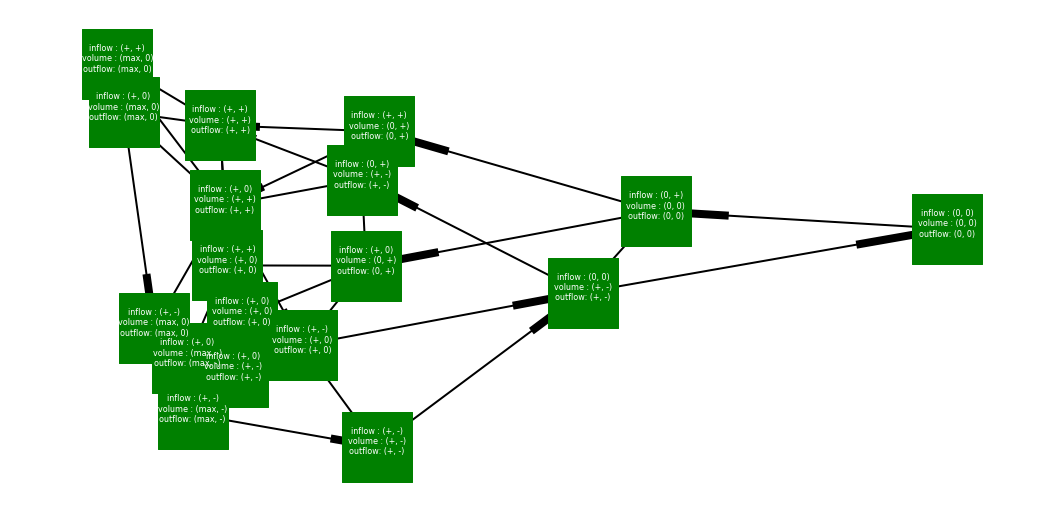

In [4]:
# The startnode is an empty tank with no inflow:
# inflow : (0, 0)
# volume : (0, 0)
# outflow: (0, 0)
startnode = State()

# The history is used to keep track of all the nodes we have seen before
history = [repr(startnode)]

# The stack keeps track of all the nodes we still have to explore
stack = [startnode]

G=nx.MultiDiGraph()
plt.figure(3,figsize=(18,9)) 
G.add_node(repr(startnode))

state_no = 0 # Counts the number of states

while len(stack) > 0 :
    
    print('-----------------------------------------------------')
    
    state_no += 1
    print('State', state_no)
    
    # Get the an unexplored node and generate its children.
    node = stack.pop(0)
    
    # Some trace prints
    print('Current node:\n' + str(node))
    
    for child in get_children(node, trace_prints = True):
        # Add the edge to the graph between these two nodes   
        G.add_edge(repr(node), repr(child))
        if repr(child) not in history: # If child not seen before or not yet in stack
            stack.append(child) # Put in stack
            G.add_node(repr(child))
            history.append(repr(child))

# Draw graph
graph_pos=nx.spectral_layout(G)
nx.draw_networkx_nodes(G,graph_pos,node_size=5000,alpha=1,node_color='green', node_shape='s')
nx.draw_networkx_edges(G,graph_pos,alpha=1,width=2, arrows=True)
nx.draw_networkx_labels(G,graph_pos,font_size=8, font_family='sans-serif', font_color='white')


# Show graph
plt.axis('off')
plt.show()